In [1]:
#Preventing aspect: 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
df_churn = pd.read_csv("ifood_df.csv")

In [2]:
df_churn.head(3)

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0


# Logistic Regression

In [3]:
np.random.seed(42)
y = df_churn['Response']  
X = df_churn.drop('Response',axis = 1)
xTrain,xTest,yTrain,yTest = train_test_split(X,y,test_size = 0.7)

In [4]:
from sklearn.linear_model import LogisticRegression
X = pd.get_dummies(X, drop_first=True)

# Split data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.7, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(xTrain, yTrain)

# Print model accuracy on test set
print("Model accuracy on test set:", log_reg.score(xTest, yTest))

Model accuracy on test set: 0.8678756476683938


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Robust Logistic Regression

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

# Load and prepare the data
df_churn = pd.read_csv('ifood_df.csv')
X = df_churn.drop(columns=['Response'])
y = df_churn['Response'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept term
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Define the Lq* norm
q_star = 2  # Dual norm for Lq is chosen as L2 here
def lq_star_norm(beta, q_star=2):
    return np.linalg.norm(beta, ord=q_star)

# Define the objective function
rho = 0.01  # Reduced regularization parameter for better convergence
def objective_function(beta, X, y, rho, q_star):
    n = len(y)
    linear_combination = X @ beta
    # Use a numerically stable version of the log-likelihood calculation
    log_likelihood = -np.sum(np.where(y == 1, -np.log(1 + np.exp(-linear_combination)), -linear_combination - np.log(1 + np.exp(-linear_combination))))
    regularization = rho * lq_star_norm(beta[1:], q_star)  # Exclude intercept from regularization
    return -(log_likelihood + regularization)  # Negative since we are maximizing

# Initial guess for beta
initial_beta = np.random.normal(0, 0.1, X_scaled.shape[1])  # Use small random values as an initial guess

# Optimize the objective function
result = minimize(
    objective_function,
    initial_beta,
    args=(X_scaled, y, rho, q_star),
    method='L-BFGS-B'
)

# Extract optimized beta
optimized_beta = result.x

# Display results
print("Optimized coefficients:", optimized_beta)

# Calculate and display overall accuracy
y_prob = 1 / (1 + np.exp(-X_scaled @ optimized_beta))
y_pred = (y_prob >= 0.5).astype(int)
accuracy = np.mean(y == y_pred)
print("Overall accuracy:", accuracy)





Optimized coefficients: [-0.05326892 -0.11163573  0.09418704 -0.19613688  0.12708476  0.08291262
  0.03252954  0.00110676 -0.07142348  0.00483797 -0.05927358  0.12055127
  0.12501729 -0.04192803 -0.06935328 -0.11085136 -0.18076723  0.01313048
 -0.03907995 -0.01456457  0.06726354 -0.19189583  0.12807444 -0.06068177
 -0.02864406 -0.01044208  0.05547664 -0.19232602 -0.06533525  0.07551938
 -0.10068707  0.03623631 -0.02083957  0.09379561 -0.06492561  0.0379514
  0.03289669  0.01850821 -0.02215523]
Overall accuracy: 0.4993197278911565


/var/folders/25/b_rbp3f508q_j0nn7xjt0z2r0000gn/T/ipykernel_32267/2995405141.py:29: RuntimeWarning: overflow encountered in exp
  log_likelihood = -np.sum(np.where(y == 1, -np.log(1 + np.exp(-linear_combination)), -linear_combination - np.log(1 + np.exp(-linear_combination))))
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


# Robust Logistic Regression Significant Variables

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import numdifftools as nd

# Load and prepare the data
df_churn = pd.read_csv('ifood_df.csv')
X = df_churn.drop(columns=['Response'])
y = df_churn['Response'].values

# Get feature names for better interpretability
feature_names = ['Intercept'] + list(X.columns)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept term
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Define the Lq* norm
q_star = 2  # Dual norm for Lq is chosen as L2 here
def lq_star_norm(beta, q_star=2):
    return np.linalg.norm(beta, ord=q_star)

# Define the objective function
rho = 0.1  # Increased regularization parameter for better stability
def objective_function(beta, X, y, rho, q_star):
    n = len(y)
    linear_combination = X @ beta
    # Cap the linear combination to prevent overflow in exp
    linear_combination = np.clip(linear_combination, -500, 500)
    # Use a numerically stable version of the log-likelihood calculation
    log_likelihood = -np.sum(np.where(y == 1, -np.log(1 + np.exp(-linear_combination)), -linear_combination - np.log(1 + np.exp(-linear_combination))))
    regularization = rho * lq_star_norm(beta[1:], q_star)  # Exclude intercept from regularization
    return -(log_likelihood + regularization)  # Negative since we are maximizing

# Initial guess for beta
initial_beta = np.random.normal(0, 0.1, X_scaled.shape[1])  # Use small random values as an initial guess

# Optimize the objective function
result = minimize(
    objective_function,
    initial_beta,
    args=(X_scaled, y, rho, q_star),
    method='L-BFGS-B'
)

# Extract optimized beta
optimized_beta = result.x

# Display results
print("Optimized coefficients:", optimized_beta)

# Calculate and display overall accuracy
y_prob = 1 / (1 + np.exp(-np.clip(X_scaled @ optimized_beta, -500, 500)))
y_pred = (y_prob >= 0.5).astype(int)
accuracy = np.mean(y == y_pred)
print("Overall accuracy:", accuracy)

# Numerical Hessian calculation to estimate standard errors
hessian_fun = nd.Hessian(lambda b: objective_function(b, X_scaled, y, rho, q_star))
H = hessian_fun(optimized_beta)

# Add regularization to the Hessian to avoid singularity (Tikhonov regularization)
epsilon = 1e-5
H_reg = H + epsilon * np.eye(H.shape[0])

# Estimate the variance-covariance matrix (inverse of the regularized Hessian)
try:
    H_inv = np.linalg.inv(H_reg)
except np.linalg.LinAlgError:
    print("Hessian matrix is singular, unable to invert.")
    H_inv = np.full(H.shape, np.nan)  # Fill with nan to indicate failure

# Calculate standard errors (sqrt of diagonal elements of variance-covariance matrix)
standard_errors = np.sqrt(np.diag(H_inv))

# Calculate z-scores for the coefficients
z_scores = optimized_beta / standard_errors

# Calculate p-values
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Display p-values to determine significance
for i, (name, coef, se, z, p) in enumerate(zip(feature_names, optimized_beta, standard_errors, z_scores, p_values)):
    print(f"{name}: Coef={coef:.4f}, SE={se:.4f}, z={z:.4f}, p-value={p:.4g}")

# Determine which variables are significant (e.g., p-value < 0.05)
significant_variables = [
    (name, coef, p)
    for name, coef, p in zip(feature_names, optimized_beta, p_values)
    if p < 0.05
]

print("\nSignificant variables (p-value < 0.05):")
for var in significant_variables:
    print(f"{var[0]}: Coef={var[1]:.4f}, p-value={var[2]:.4g}")




Optimized coefficients: [ 3.07356904e+08  1.57589643e+07 -1.24758388e+07  1.76661215e+07
  9.95200849e+07  1.82612572e+07 -2.36170980e+07 -4.97531718e+07
  1.71668239e+07  1.35742905e+07 -3.24891843e+07 -1.26796975e+07
 -7.22547501e+06  6.67209849e+05  6.73247478e+07  3.50130416e+07
 -2.34782840e+07 -1.98292317e+07 -3.53046480e+07 -4.03230779e+07
 -4.48782327e+07 -1.29626834e+07  1.73252207e+03 -1.08205926e+03
  4.79850221e+06 -9.94333628e+07 -2.68085916e+07  1.21986538e+07
 -3.18206351e+07  3.87016646e+07 -8.45027493e+06  1.79982850e+07
  4.88854297e+07 -1.01362393e+07 -1.67094405e+07 -3.36480642e+06
 -7.11105725e+06 -4.39510470e+06 -5.24431722e+07]
Overall accuracy: 0.10294784580498866
Intercept: Coef=307356903.8541, SE=316.2278, z=971947.8708, p-value=0
Income: Coef=15758964.3173, SE=316.2351, z=49833.0613, p-value=0
Kidhome: Coef=-12475838.8061, SE=316.2351, z=-39451.1532, p-value=0
Teenhome: Coef=17666121.4694, SE=316.2278, z=55865.1812, p-value=0
Recency: Coef=99520084.8559, SE=3

# K Means


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       378
           1       0.67      0.48      0.56        63

    accuracy                           0.89       441
   macro avg       0.79      0.72      0.75       441
weighted avg       0.88      0.89      0.88       441

Overall accuracy: 0.89


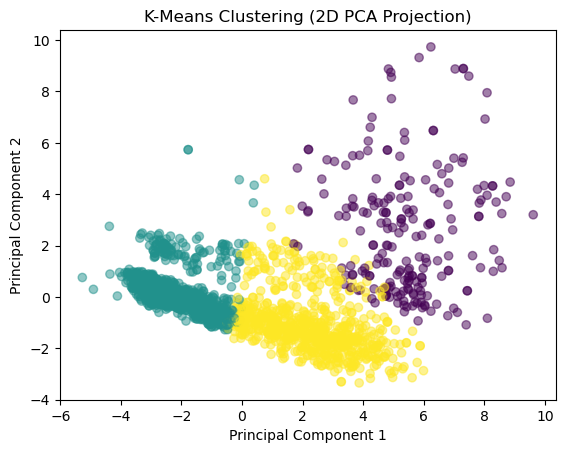

In [19]:
!pip install matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'ifood_df.csv'
df_churn = pd.read_csv(file_path)

# Define features and target
X = df_churn.drop(['Response'], axis=1)
y = df_churn['Response']

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pre-processing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline for robust logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print classification report to evaluate performance
print(classification_report(y_test, y_pred))

# Print overall accuracy
print(f'Overall accuracy: {accuracy_score(y_test, y_pred):.2f}')

# Implement K-Means clustering
# Preprocess the entire feature set
X_processed = preprocessor.fit_transform(X)

# Define and fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_processed)

# Add cluster labels to the original dataframe
df_churn['Cluster'] = kmeans.labels_

# Plotting the clusters (using first two principal components for visualization)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering (2D PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [5]:
# SIGNIFICANT VARIABLES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
file_path = 'ifood_df.csv'
df_churn = pd.read_csv(file_path)

# Encode target variable as binary
y = df_churn['Response']

# Identify numeric and categorical columns
numeric_features = df_churn.select_dtypes(include=['int64', 'float64']).columns.difference(['Response'])
categorical_features = df_churn.columns.difference(numeric_features.union(['Response']))

# One-hot encode categorical variables if any exist
if len(categorical_features) > 0:
    X_categorical = pd.get_dummies(df_churn[categorical_features], drop_first=True)
else:
    X_categorical = pd.DataFrame()

# Combine numeric and encoded categorical features
if not X_categorical.empty:
    X = pd.concat([df_churn[numeric_features], X_categorical], axis=1)
else:
    X = df_churn[numeric_features]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.7, random_state=42)

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(yTrain, xTrain)
result = logit_model.fit()

# Print model summary to get coefficients and p-values
print(result.summary())

# Evaluate model accuracy on test set
predictions = result.predict(xTest) >= 0.5  # Convert probabilities to binary outcomes
accuracy = np.mean(predictions == yTest)
print("Model accuracy on test set:", accuracy)



         Current function value: 0.254580
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                  661
Model:                          Logit   Df Residuals:                      627
Method:                           MLE   Df Model:                           33
Date:                Tue, 03 Dec 2024   Pseudo R-squ.:                  0.4250
Time:                        14:14:24   Log-Likelihood:                -168.28
converged:                      False   LL-Null:                       -292.67
Covariance Type:            nonrobust   LLR p-value:                 6.146e-35
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
AcceptedCmp1             0.9743   7.68e+06   1.27e-07      1.000    -1.5e+07     1.5e+07
AcceptedCmp2            -0.5607   7

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Robust K Means Clustering

In [8]:
import gurobipy as gp

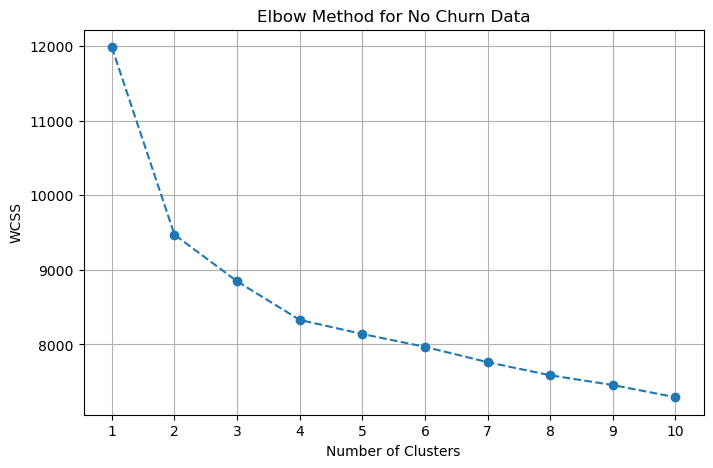

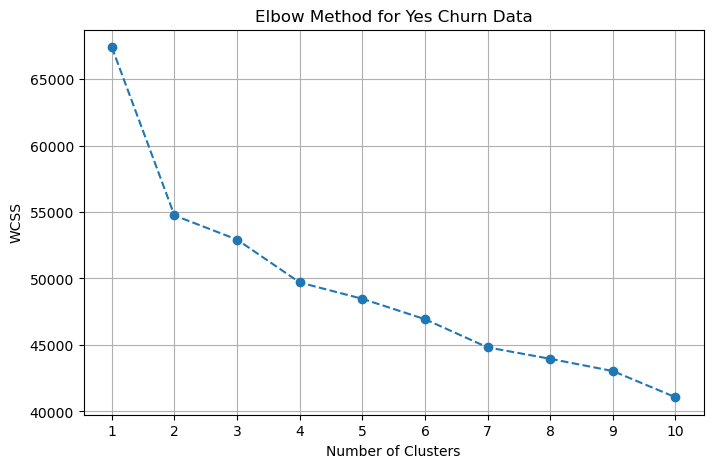

In [9]:
#split up the churning and on-churning observations for clustering
nochurndf = df_churn[df_churn["Response"] == 1]
yeschurndf = df_churn[df_churn["Response"] == 0]

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#elbow method for selecting the appropriate amount of clusters
def plot_elbow_method(df, max_clusters=10, title="Elbow Method"):
    # Drop 'Response' if present
    if 'Response' in df.columns:
        df = df.drop(columns=['Response'])
    
    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)
    
    # Scale the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Compute WCSS for different numbers of clusters
    wcss = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(df_scaled)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True)
    plt.show()
# Apply the elbow method to nochurndf
plot_elbow_method(nochurndf, title="Elbow Method for No Churn Data")

# Apply the elbow method to yeschurndf
plot_elbow_method(yeschurndf, title="Elbow Method for Yes Churn Data")

In [17]:
# ROBUST K-MEANS

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

# Load and prepare the data
df_churn = pd.read_csv('ifood_df.csv')
X = df_churn.drop(columns=['Response']).values
y = df_churn['Response'].values  # Target variable with values 0 and 1

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Parameters for robust k-means
n_clusters = 2  # Number of clusters (since Response has 2 classes)
max_iter = 100  # Maximum number of iterations
lambda_param = 0.5  # Lambda parameter for adjustment

# Initialize cluster centroids randomly
np.random.seed(42)
centroids = X_scaled[np.random.choice(X_scaled.shape[0], n_clusters, replace=False)]

# K-means loop
for iteration in range(max_iter):
    # Assign points to the nearest cluster
    distances = np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Update centroids using the robust adjustment formulation
    new_centroids = np.zeros_like(centroids)
    for k in range(n_clusters):
        cluster_points = X_scaled[labels == k]
        if len(cluster_points) == 0:
            continue
        
        # Calculate c_k^new
        c_k_new = np.mean(cluster_points, axis=0)
        
        # Calculate d_max
        d_max = np.max(np.linalg.norm(cluster_points - c_k_new, axis=1))
        
        # Calculate c_k^adjusted
        c_k_old = centroids[k]
        if d_max > 0:  # Avoid division by zero
            c_k_adjusted = c_k_old + lambda_param * (c_k_new - c_k_old) / d_max
        else:
            c_k_adjusted = c_k_old
        
        new_centroids[k] = c_k_adjusted

    # Check for convergence (if centroids do not change significantly)
    if np.allclose(centroids, new_centroids, atol=1e-6):
        break
    centroids = new_centroids

# Display final centroids
print("Final centroids:", centroids)

# Assign final labels
final_distances = np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2)
final_labels = np.argmin(final_distances, axis=1)

# Display final cluster assignments
print("Final cluster assignments:", final_labels)

# Calculate and display overall accuracy
y_pred = final_labels
accuracy = np.mean(y == y_pred)
print("Overall accuracy:", accuracy)

# Calculate and display adjusted Rand index
ari = adjusted_rand_score(y, y_pred)
print("Adjusted Rand Index (ARI):", ari)





Final centroids: [[ 1.12353433 -0.73173957 -0.36774466  0.03101138  1.10203231  0.87745303
   1.19891295  0.95911497  0.85742884  0.61503921 -0.37989994  0.5746649
   1.14050009  0.88798644 -0.8276819   0.03882004  0.27419779  0.72888893
   0.4866372   0.19373235 -0.0409702   0.          0.          0.17570227
   0.08040966 -0.00298089 -0.05009526  0.06873408 -0.0294495   0.05422625
  -0.06211206 -0.15480778  0.04387248  0.03175933  0.01934469  1.31228327
   1.30717012  0.60801767]
 [-0.46021268  0.30941738  0.13155933 -0.04267045 -0.44077618 -0.39289992
  -0.50851451 -0.42518662 -0.33526259 -0.28221098  0.13877841 -0.22053189
  -0.50099862 -0.39372713  0.35927247 -0.02427946 -0.13117023 -0.27989486
  -0.15285279 -0.09002533  0.01624725  0.          0.         -0.07687129
  -0.03305214 -0.00975303 -0.00208051  0.02811709 -0.00491753 -0.02977557
   0.0775592   0.06591828 -0.05306381  0.01044785 -0.02360084 -0.54213812
  -0.53739877 -0.23745356]]
Final cluster assignments: [0 1 0 ... 0 0

# second try - Robust K-Means

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, adjusted_rand_score

# Load the dataset
ifood_data_path = 'ifood_df.csv'
ifood_data = pd.read_csv(ifood_data_path)

# Preprocessing
# Separate features (X) and target variable (y)
X_ifood = ifood_data.drop(columns=['Response'])
y_ifood = ifood_data['Response'].values

# Standardize the features for numerical stability
scaler = StandardScaler()
X_ifood_scaled = scaler.fit_transform(X_ifood)

# Define robust k-means functions
def robust_k_means(X, k, max_iter=100, lambda_param=0.5, tol=1e-4):
    """
    Robust k-means clustering implementation.

    Parameters:
        X (array-like): The dataset.
        k (int): Number of clusters.
        max_iter (int): Maximum number of iterations.
        lambda_param (float): Lambda parameter for center adjustment.
        tol (float): Tolerance for convergence.

    Returns:
        centers (array): Cluster centers.
        labels (array): Cluster assignments.
    """
    n_samples, n_features = X.shape
    # Initialize cluster centers randomly
    np.random.seed(42)
    centers = X[np.random.choice(n_samples, k, replace=False)]

    for iteration in range(max_iter):
        # Assign points to the nearest cluster center
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)  # Distances to all centers
        labels = np.argmin(distances, axis=1)

        new_centers = np.zeros_like(centers)
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                # Update c_k^new
                c_k_new = np.mean(cluster_points, axis=0)
                # Calculate d_max
                d_max = np.max(np.linalg.norm(cluster_points - c_k_new, axis=1))
                # Adjust c_k
                centers[i] += lambda_param * (c_k_new - centers[i]) / max(d_max, tol)
                new_centers[i] = centers[i]
            else:
                new_centers[i] = centers[i]  # Retain old center if no points in cluster

        # Check for convergence
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers

    return centers, labels

# Run robust k-means on the data with 2 clusters (Response = 0 or 1)
k = 2
centers_ifood, labels_ifood = robust_k_means(X_ifood_scaled, k)

# Evaluate clustering by comparing to the "Response" labels
# Map clusters to response labels for better comparison
cluster_to_label_ifood = {i: np.bincount(y_ifood[labels_ifood == i]).argmax() for i in range(k)}

# Map predicted clusters to response labels
predicted_labels_ifood = np.array([cluster_to_label_ifood[label] for label in labels_ifood])

# Calculate metrics
accuracy_ifood_kmeans = accuracy_score(y_ifood, predicted_labels_ifood)
adjusted_rand_ifood_kmeans = adjusted_rand_score(y_ifood, labels_ifood)

# Output results
print("Accuracy:", accuracy_ifood_kmeans)
print("Adjusted Rand Index:", adjusted_rand_ifood_kmeans)


Accuracy: 0.8489795918367347
Adjusted Rand Index: 0.11723250423809196
